In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.mobilenetv3 import MobileNetV3
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/mobilenet")
data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

13


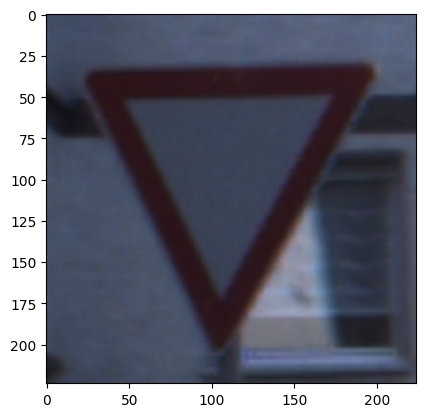

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = MobileNetV3(output_size=num_class).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
MobileNetV3                                                       --
├─Sequential: 1-1                                                 --
│    └─Conv2dNormActivation: 2-1                                  --
│    │    └─Conv2d: 3-1                                           432
│    │    └─BatchNorm2d: 3-2                                      32
│    │    └─Hardswish: 3-3                                        --
│    └─InvertedResidualBlockV3: 2-2                               --
│    │    └─ResBlock: 3-4                                         752
│    └─InvertedResidualBlockV3: 2-3                               --
│    │    └─LinearBottleneckV3: 3-5                               3,440
│    └─InvertedResidualBlockV3: 2-4                               --
│    │    └─ResBlock: 3-6                                         4,440
│    └─InvertedResidualBlockV3: 2-5                               --
│    │    └─LinearBot

# training

In [13]:
epoches = 10
acc_iters = 256 // BATCH_SIZE

In [14]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [15]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 416/416 [01:14<00:00,  5.59it/s]


epoch 1 : 0.008963472969928542


100%|██████████| 416/416 [01:13<00:00,  5.63it/s]


epoch 2 : 0.0020252560965183454


100%|██████████| 416/416 [01:15<00:00,  5.51it/s]


epoch 3 : 0.0005500066042714025


100%|██████████| 416/416 [01:26<00:00,  4.80it/s]


epoch 4 : 0.0002786110618532033


100%|██████████| 416/416 [01:27<00:00,  4.78it/s]


epoch 5 : 0.00018970973456169723


100%|██████████| 416/416 [01:15<00:00,  5.55it/s]


epoch 6 : 0.000139022138735247


100%|██████████| 416/416 [01:12<00:00,  5.73it/s]


epoch 7 : 0.00013658024715878215


100%|██████████| 416/416 [01:10<00:00,  5.88it/s]


epoch 8 : 0.00013510695481035493


100%|██████████| 416/416 [01:09<00:00,  6.00it/s]


epoch 9 : 0.00011872551661003154


100%|██████████| 416/416 [01:09<00:00,  5.95it/s]

epoch 10 : 6.0300808154436846e-05


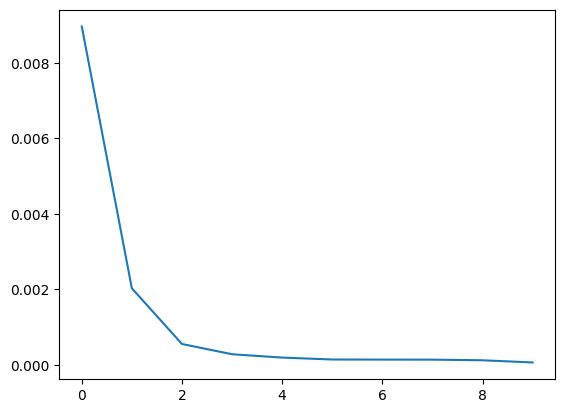

In [17]:
plt.plot(training_loss)

# inference

In [18]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [19]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [21]:
evaluator = ClassificationEvaluator(num_class, device)

In [22]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [00:24<00:00,  8.11it/s]

[[ 60   0   0 ...   0   0   0]
 [  8 706   2 ...   0   0   0]
 [  0   1 746 ...   0   0   0]
 ...
 [  0   0   0 ...  88   0   0]
 [  0   0   0 ...   0  60   0]
 [  0   0   0 ...   0   1  59]]


In [24]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 1.0
1         : 0.9805555555555555
2         : 0.9946666666666667
3         : 0.9644444444444444
4         : 0.9515151515151515
5         : 0.9746031746031746
6         : 0.84
7         : 0.9044444444444445
8         : 0.98
9         : 1.0
10        : 1.0
11        : 0.9595238095238096
12        : 0.9797101449275363
13        : 0.9958333333333333
14        : 0.9888888888888889
15        : 0.9904761904761905
16        : 1.0
17        : 0.8583333333333333
18        : 0.9025641025641026
19        : 0.5666666666666667
20        : 0.7555555555555555
21        : 0.8222222222222222
22        : 0.75
23        : 0.94
24        : 0.9777777777777777
25        : 0.9229166666666667
26        : 0.9944444444444445
27        : 0.5
28        : 1.0
29        : 1.0
30        : 0.6866666666666666
31        : 0.9444444444444444
32        : 0.9
33        : 0.8476190476190476
34        : 0.75
35        : 0.9487179487179487
36        : 1.0
37        : 0.5
38        : 0.9492753623188406
39        :

In [25]:
per_class_acc.mean()

0.8759607090191013

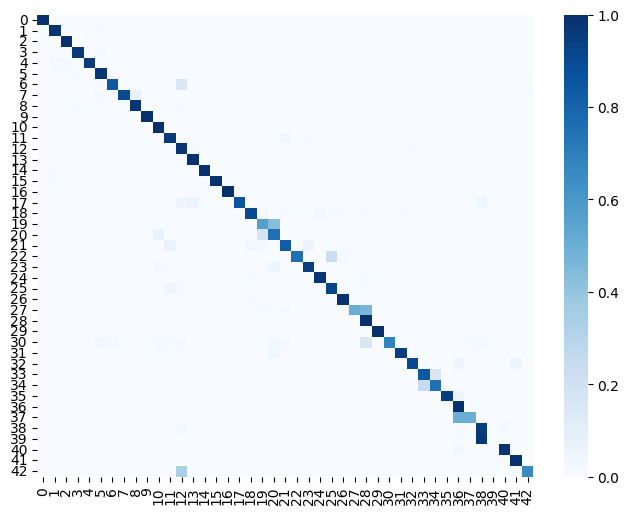

In [26]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [27]:
model_path = artifact_path / f'mobilenetV3.large.pth'

In [28]:
torch.save(model.state_dict(), model_path)

In [29]:
get_file_size(model_path)

'18.21MB'

In [30]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>